In [1]:
# imports

import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.signal import sosfiltfilt, butter, hilbert
import scipy.signal as signal
from math import ceil
import matplotlib.pyplot as plt
import scipy.io

import mne
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# show keys

subject_file_raw = "data/stroke/P1_post_training.mat"
subject_raw = scipy.io.loadmat(subject_file_raw)

for key in subject_raw.keys():
    print(key)


__header__
__version__
__globals__
fs
trig
y


/var/folders/bz/6p54_6gn2jsgwrv13d1hswq80000gn/T/ipykernel_2206/1240179517.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[channel].set_xticklabels((axs[channel].get_xticks()*(1/sampling_rate)))
/var/folders/bz/6p54_6gn2jsgwrv13d1hswq80000gn/T/ipykernel_2206/1240179517.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[n_channels-1].set_xticklabels((axs[n_channels-1].get_xticks()*(1/sampling_rate)))


Text(0.5, 0, 'Time (sec)')

<Figure size 2000x1600 with 0 Axes>

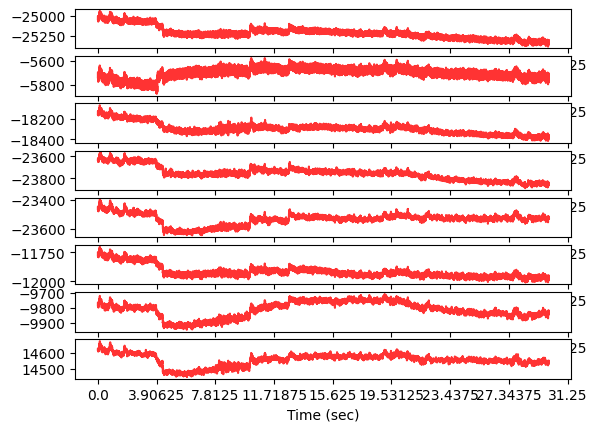

In [3]:
# plot first 30 seconds of raw data 
subject_file_raw = "data/stroke/P1_post_training.mat"
subject_raw = scipy.io.loadmat(subject_file_raw)

sampling_rate = subject_raw["fs"][0][0]

first_trial_end = ceil(30 * sampling_rate)

n_channels = subject_raw["y"].shape[1]
n_channels = 8 #just visualising first 8 channels
fig = plt.figure(figsize=(20, 16))
fig, axs = plt.subplots(n_channels)

for channel in range(n_channels):

    t = [i for i in range(subject_raw["y"].shape[0])]

    sig = subject_raw["y"][:first_trial_end,channel]
    # sos = signal.butter(4, [8,30], 'bp', fs=sampling_rate, output='sos')
    # filtered = signal.sosfilt(sos, sig)
    axs[channel].plot(t[:first_trial_end], sig, c='red', alpha=0.8)
    axs[channel].set_xticklabels((axs[channel].get_xticks()*(1/sampling_rate)))

axs[n_channels-1].set_xticklabels((axs[n_channels-1].get_xticks()*(1/sampling_rate)))
axs[n_channels-1].set_xlabel('Time (sec)')

/var/folders/bz/6p54_6gn2jsgwrv13d1hswq80000gn/T/ipykernel_2206/736342796.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((ax.get_xticks()*(1/sampling_rate)))


Text(0.5, 0, 'Time (sec)')

<Figure size 2000x1600 with 0 Axes>

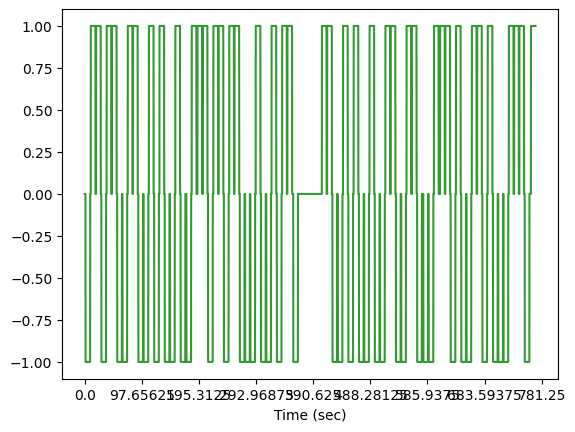

In [5]:
#show triggers (cues for left hand or right hand)

fig = plt.figure(figsize=(20, 16))
fig, ax = plt.subplots(1)

t = [i for i in range(subject_raw["y"].shape[0])]

ax.plot(
    t,
    subject_raw["trig"], c='green', alpha=0.8)

ax.set_xticklabels((ax.get_xticks()*(1/sampling_rate)))

ax.set_xlabel('Time (sec)')

In [6]:
# load filtered subject.
# see preprocess.m on how data is filtered.

subject_file = "data/filtered/P1_post_training_filtered.mat"
subject = scipy.io.loadmat(subject_file)

for key in subject.keys():
    print(key)


__header__
__version__
__globals__
a
b
eegData
filteredData
fs
samplingRate
trig


/var/folders/bz/6p54_6gn2jsgwrv13d1hswq80000gn/T/ipykernel_2206/4073333819.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[channel].set_xticklabels((axs[channel].get_xticks()*(1/sampling_rate)))
/var/folders/bz/6p54_6gn2jsgwrv13d1hswq80000gn/T/ipykernel_2206/4073333819.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[n_channels-1].set_xticklabels((axs[n_channels-1].get_xticks()*(1/sampling_rate)))


Text(0.5, 0, 'Time (sec)')

<Figure size 2000x1600 with 0 Axes>

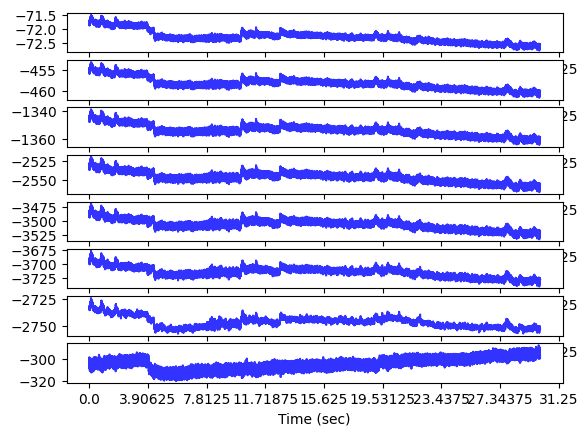

In [7]:
# plot filtered data, first 30 seconds.

sampling_rate = subject["fs"][0][0]

first_thirty = ceil(30 * sampling_rate)

n_channels = subject["filteredData"].shape[1]
n_channels = 8 #just visualising first 8 channels
fig = plt.figure(figsize=(20, 16))
fig, axs = plt.subplots(n_channels)

for channel in range(n_channels):

    t = [i for i in range(subject["filteredData"].shape[0])]

    sig = subject["filteredData"][:first_thirty,channel]
        # filtering step has already been completed in matlab
        # sos = signal.butter(4, [8,30], 'bp', fs=sampling_rate, output='sos')
        # filtered = signal.sosfilt(sos, sig)
    axs[channel].plot(t[:first_thirty], sig, c='blue', alpha=0.8)
    axs[channel].set_xticklabels((axs[channel].get_xticks()*(1/sampling_rate)))

axs[n_channels-1].set_xticklabels((axs[n_channels-1].get_xticks()*(1/sampling_rate)))
axs[n_channels-1].set_xlabel('Time (sec)')

In [8]:
# initialise epoch arrays. sorry, hacky
# an epoch is an 8 second trial (labelled as either being cued left or right,
# inside the subject["trig"] array)
epochs = []
start_idx = 0
end_idx = -1 
for idx, cue in enumerate(subject["trig"]):
    if idx+1 == subject["trig"].shape[0] or cue != subject["trig"][idx+1]: 
        start_idx = end_idx + 1
        end_idx = idx
        epochs.append(
            np.zeros(
                (end_idx + 1 - start_idx, 16)
            )
        )
        if idx +1 == subject["trig"].shape[0]:
            break


print(subject["trig"].shape[0])
print(subject["filteredData"].shape[0])
print(sum([epoch.shape[0] for epoch in epochs]))

# show shapes: we see that there's a long inter-trial epoch at the start 
# then the trials begin. there are random length inter-trial epochs in the middle
[epoch.shape for epoch in epochs]

197343
197343
197343


[(351, 16),
 (2048, 16),
 (256, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (256, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (256, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (480, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (472, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (280, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (280, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (256, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (496, 16),
 (2048, 16),


In [9]:
# load the filtered data into the epochs
# super hacky sorry
sample_index = 0
for epoch in epochs:
    epoch_len = epoch.shape[0]
    for epoch_sample_index in range(epoch_len):
        epoch[epoch_sample_index,:] = subject["filteredData"][sample_index,:]
        sample_index += 1


In [10]:
#just checking if frames were loaded correctly, looks OK
epochs[-1][-1,:] == subject["filteredData"][-1,:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [11]:
# now build X and y
# X : ndarray, shape (n_epochs, n_channels, n_times)
#  y : ndarray, shape (n_epochs,)
            # The class for each epoch.
n_channels = 16
n_times = 2048


all_epoch_labels = []
for idx, cue in enumerate(subject["trig"]):
    if idx+1 == subject["trig"].shape[0] or cue != subject["trig"][idx+1]: 
        all_epoch_labels.append(cue) 
        if idx +1 == subject["trig"].shape[0]:
            break

X = []
y = []
for epoch_idx, epoch in enumerate(epochs):
    if len(epoch) == n_times:
        X.append(epoch)
        y.append(all_epoch_labels[epoch_idx])

X = np.asarray(X)

all_epoch_labels = 0
epochs = 0

y = np.asarray(y)
y = y.flatten()
print(y.shape)
X = X.reshape((80, 16, 2048))
X.shape


(80,)


(80, 16, 2048)

In [12]:
# now load test data
test_subject_file = "data/filtered/P1_post_test_filtered.mat"
test_subject = scipy.io.loadmat(test_subject_file)


In [13]:
# initialise test epoch arrays. sorry, hacky
test_epochs = []
start_idx = 0
end_idx = -1 
for idx, cue in enumerate(test_subject["trig"]):
    if idx+1 == test_subject["trig"].shape[0] or cue != test_subject["trig"][idx+1]: 
        start_idx = end_idx + 1
        end_idx = idx
        test_epochs.append(
            np.zeros(
                (end_idx + 1 - start_idx, 16)
            )
        )
        if idx +1 == test_subject["trig"].shape[0]:
            break

In [14]:
print(test_subject["trig"].shape[0])
print(test_subject["filteredData"].shape[0])
print(sum([epoch.shape[0] for epoch in test_epochs]))
[epoch.shape for epoch in test_epochs]

194088
194088
194088


[(343, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (672, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (680, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (280, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (280, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (272, 16),
 (2048, 16),
 (280, 16),
 (2048, 16),
 (696, 16),
 (2048, 16),
 (264, 16),
 (2048, 16),


In [15]:
# load the filtered test data into the test epochs
# super hacky sorry
sample_index = 0
for epoch in test_epochs:
    epoch_len = epoch.shape[0]
    for epoch_sample_index in range(epoch_len):
        epoch[epoch_sample_index,:] = test_subject["filteredData"][sample_index,:]
        sample_index += 1

In [16]:
#now build X_test and y_test
n_channels = 16
n_times = 2048

all_test_epoch_labels = []
for idx, cue in enumerate(test_subject["trig"]):
    if idx+1 == test_subject["trig"].shape[0] or cue != test_subject["trig"][idx+1]: 
        all_test_epoch_labels.append(cue) 
        if idx +1 == test_subject["trig"].shape[0]:
            break

X_test = []
y_test = []
for epoch_idx, epoch in enumerate(test_epochs):
    if len(epoch) == n_times:
        X_test.append(epoch)
        y_test.append(all_test_epoch_labels[epoch_idx])

X_test = np.asarray(X_test)
X_test.shape

X_test = X_test.reshape((80, 16, 2048))
y_test = np.asarray(y_test)
y_test = y_test.flatten()
print(y_test.shape)
X_test.shape

(80,)


(80, 16, 2048)

In [17]:
#train and predict!

# CSP
csp = mne.decoding.CSP(
    n_components=8, 
    reg=None,
    log=True,
    cov_est='concat',
    transform_into='average_power', 
    norm_trace=False, 
    cov_method_params=None, 
    rank=None, 
    component_order='mutual_info')

Z = csp.fit_transform(X, y)
Z.shape

# LDA
lda = LinearDiscriminantAnalysis(
    solver='svd',
    shrinkage=None,
    priors=None,
    n_components=None,
    store_covariance=False,
    tol=0.0001,
    covariance_estimator=None)

lda.fit(Z, y)

# test! 

Z_test = csp.transform(X_test)
print(Z_test.shape)
acc = lda.score(
    Z_test,
    y_test
)
print(acc * 100, '%')



Computing rank from data with rank=None
    Using tolerance 2.2e+04 (2.2e-16 eps * 16 dim * 6.2e+18  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e+04 (2.2e-16 eps * 16 dim * 6.1e+18  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
(80, 8)
93.75 %


In [18]:
#tune CSP's hyper parameters.

# Define the parameter grid
param_grid = {
    'csp__reg': [0.1, 0.01, 0.001, 0.0001],
    'csp__n_components': [2,3,4,6,8,10]
}

# Instantiate the CSP and LDA classifiers
csp = CSP()
lda = LinearDiscriminantAnalysis()

# Create a pipeline with CSP and LDA
pipeline = Pipeline([
    ('csp', csp),
    ('lda', lda)
])

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=3,  # Adjust the number of iterations as needed
    scoring='accuracy',  # Adjust the scoring metric as needed
    cv=5  # Adjust the number of cross-validation folds as needed
)

# Fit RandomizedSearchCV to your training data
random_search.fit(X, y)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Computing rank from data with rank=None
    Using tolerance 2e+04 (2.2e-16 eps * 16 dim * 5.6e+18  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2e+04 (2.2e-16 eps * 16 dim * 5.6e+18  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2e+04 (2.2e-16 eps * 16 dim * 5.6e+18  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2e+04 (2.2e-16 eps * 16 dim * 5.5e+18  max singular value)
    Esti

In [19]:
# test with best params
cv = ShuffleSplit(10, test_size=0.2, random_state=42)

# Instantiate the CSP and LDA classifiers
csp = CSP(
    n_components=8,
    reg=0.001,
)
lda = LinearDiscriminantAnalysis()

# Create a pipeline with CSP and LDA
pipeline = Pipeline([
    ('csp', csp),
    ('lda', lda)
])
scores = cross_val_score(pipeline, X_test, y_test, cv=cv, n_jobs=None)
print("mean score", scores.mean(), "with std", scores.std())

Computing rank from data with rank=None


    Using tolerance 2e+04 (2.2e-16 eps * 16 dim * 5.5e+18  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e+04 (2.2e-16 eps * 16 dim * 6e+18  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e+04 (2.2e-16 eps * 16 dim * 6e+18  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 2e+04 (2.2e-16 eps * 16 dim * 5.6e+18  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 co